<a href="https://www.kaggle.com/code/kmljts/binary-pneumonia-detection?scriptVersionId=179457062" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# import os
# for root, folders, filenames in os.walk('/kaggle/input'):
#    print(root, folders)

In [2]:
!nvidia-smi

Fri May 24 02:21:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              27W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import datasets, transforms, models
from torchmetrics import ConfusionMatrix, AUROC
from mlxtend.plotting import plot_confusion_matrix

import os
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import random

from tqdm.auto import tqdm

In [4]:
input_dir = '/kaggle/input'
dataset_path = os.path.join(input_dir, 'chest-xray-pneumonia/chest_xray/chest_xray')
train_dataset_path = os.path.join(dataset_path, 'train')
val_dataset_path = os.path.join(dataset_path, 'val')
test_dataset_path = os.path.join(dataset_path, 'test')

output_dir = '/kaggle/working'
model_save_path = os.path.join(output_dir, 'models')
result_save_path = os.path.join(output_dir, 'results')
plot_save_path = os.path.join(output_dir, 'plots')

os.makedirs(model_save_path, exist_ok=True)
os.makedirs(result_save_path, exist_ok=True)
os.makedirs(plot_save_path, exist_ok=True)

train_dataset_path, val_dataset_path, test_dataset_path, model_save_path, result_save_path, plot_save_path

('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test',
 '/kaggle/working/models',
 '/kaggle/working/results',
 '/kaggle/working/plots')

In [5]:
# import shutil
# shutil.rmtree(output_dir)

In [6]:
# sorted(os.listdir(model_save_path)), sorted(os.listdir(result_save_path)), sorted(os.listdir(plot_save_path))

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [8]:
torch.cuda.empty_cache()

In [9]:
# BATCH_SIZE = 4
# LR = 1e-6
BATCH_SIZE = 16
LR = 1e-7
EPOCHS = 100

USE_BEST_MODEL_YET = False
NORMALIZE = False
# NORMALIZE = True

In [10]:
torch.cuda.empty_cache()

In [11]:
def current_datetime():
    cur_datetime = datetime.now() + timedelta(hours=5, minutes=30) # IST
    return cur_datetime.strftime("%Y-%m-%d_%H-%M-%S")

def unique_file_namer(model_name, n_epochs=EPOCHS, learning_rate=LR, batch_size=BATCH_SIZE):
    return f'{current_datetime()}_{model_name}_{n_epochs}_{learning_rate:.2e}_{batch_size}'

In [12]:
class UnNormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor.clamp(-1, 1) * self.std + self.mean
    
class Identity:
    def __call__(self, tensor):
        return tensor

img_to_tensor = transforms.Compose([
    transforms.Resize((448,) * 2),
#     transforms.RandomRotation(30),
#     transforms.RandomResizedCrop((128,) * 2),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.0),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) if NORMALIZE else Identity()
])

tensor_to_img = transforms.Compose([
    UnNormalize(0.5, 0.5) if NORMALIZE else Identity(),
    transforms.ToPILImage()
])

In [13]:
def random_sample(dataset, classes):
    input, target = random.choice(dataset)

    image = tensor_to_img(input)
    display(image)
    print('Target:', classes[target])

def random_pred(dataset, model, classes):
    input, target = random.choice(dataset)

    input = input.to(device)
    image = tensor_to_img(input)
    display(image)

    model.eval()
    with torch.inference_mode():
        logits = model(input.unsqueeze(0))

    print(f'{"Raw Logits: ":30}{logits}') # raw logits
    probs = logits.softmax(1)
    print(f'{"Prediction Probabilities: ":30}{probs}') # prediction probabilities
    label = probs.argmax(1).item()
    print(f'{"Prediction Labels: ":30}{label}', end='\n\n') # prediction label
    
    print('Prediction:', classes[label])
    print('Target:', classes[target])

def dataset_analyzer(dataset, classes):
    freqs = [0] * len(classes)
    for X, y in dataset:
        freqs[y] += 1

    return {classes[i]: freqs[i] for i in range(len(classes))}

In [14]:
def harmonic_mean(a, b):
    if a + b == 0: return 0
    return 2 * a * b / (a + b)

def manage_nan(tensor):
    return tensor if not torch.isnan(tensor).item() else torch.tensor(0.0).to(device)

def confmat_to_accuracy(confmat): # micro
    num_classes = confmat.shape[0]

    correct_preds = 0
    for i in range(num_classes):
        correct_preds += confmat[i, i]
    all_preds = confmat.sum()

    acc = manage_nan(correct_preds / all_preds)

    return acc.item()

def confmat_to_precision(confmat): # macro
    num_classes = confmat.shape[0]

    if num_classes == 2:
        return manage_nan(confmat[1, 1] / confmat[:, 1].sum()).item()

    prec = 0
    for i in range(num_classes):
        prec += manage_nan(confmat[i, i] / confmat[:, i].sum())
    prec /= num_classes

    return prec.item()

def confmat_to_recall(confmat): # macro
    num_classes = confmat.shape[0]

    if num_classes == 2:
        return manage_nan(confmat[1, 1] / confmat[1].sum()).item()

    rec = 0
    for i in range(num_classes):
        rec += manage_nan(confmat[i, i] / confmat[i].sum())
    rec /= num_classes

    return rec.item()

def confmat_to_f1score(confmat): # macro
    num_classes = confmat.shape[0]

    if num_classes == 2:
        return harmonic_mean(confmat_to_precision(confmat), confmat_to_recall(confmat))

    f1 = 0
    for i in range(num_classes):
        prec = manage_nan(confmat[i, i] / confmat[:, i].sum())
        rec = manage_nan(confmat[i, i] / confmat[i].sum())

        f1 += harmonic_mean(prec, rec)
    f1 /= num_classes

    return f1.item()

In [15]:
train_dataset = datasets.ImageFolder(train_dataset_path, transform=img_to_tensor)

len(train_dataset), random.choice(train_dataset), train_dataset.classes

(5216,
 (tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.1137, 0.1294, 0.1216],
           [0.0000, 0.0000, 0.0000,  ..., 0.1098, 0.1216, 0.1216],
           [0.0000, 0.0000, 0.0000,  ..., 0.1137, 0.1176, 0.1216],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
  
          [[0.0000, 0.0000, 0.0000,  ..., 0.1137, 0.1294, 0.1216],
           [0.0000, 0.0000, 0.0000,  ..., 0.1098, 0.1216, 0.1216],
           [0.0000, 0.0000, 0.0000,  ..., 0.1137, 0.1176, 0.1216],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
  
          [[0.0000, 0.0000, 0.0000,  ..., 0.1137, 0.1294, 0.1216],
           [0.0000, 0.0000, 0.0000,  ..., 0.1098, 0.1216, 0.1216],
           [0.0

In [16]:
val_dataset = datasets.ImageFolder(val_dataset_path, transform=img_to_tensor)

len(val_dataset), random.choice(val_dataset), val_dataset.classes

(16,
 (tensor([[[0.0314, 0.0392, 0.0549,  ..., 0.0000, 0.0000, 0.0000],
           [0.0314, 0.0392, 0.0549,  ..., 0.0000, 0.0000, 0.0000],
           [0.0314, 0.0392, 0.0549,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
  
          [[0.0314, 0.0392, 0.0549,  ..., 0.0000, 0.0000, 0.0000],
           [0.0314, 0.0392, 0.0549,  ..., 0.0000, 0.0000, 0.0000],
           [0.0314, 0.0392, 0.0549,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
  
          [[0.0314, 0.0392, 0.0549,  ..., 0.0000, 0.0000, 0.0000],
           [0.0314, 0.0392, 0.0549,  ..., 0.0000, 0.0000, 0.0000],
           [0.031

In [17]:
test_dataset = datasets.ImageFolder(test_dataset_path, transform=img_to_tensor)

len(test_dataset), random.choice(test_dataset), test_dataset.classes

(624,
 (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  0),
 ['NORMAL', 'PNEUMONIA'])

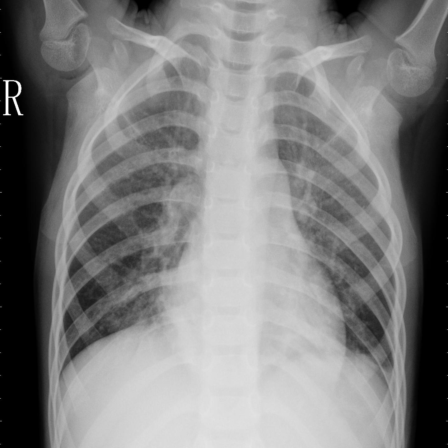

Target: PNEUMONIA


In [18]:
random_sample(train_dataset, classes=train_dataset.classes)

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [20]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(326, 1, 39)

In [21]:
# n_samples = torch.zeros(2)

# for X, y in train_dataset:
#     n_samples[y] += 1

n_samples = torch.tensor([1341, 3875]).to(device)

n_samples

tensor([1341, 3875], device='cuda:0')

In [22]:
# class_weights = n_samples.sum() / n_samples
class_weights = torch.tensor([1.0, 0.1]).to(device)

class_weights

tensor([1.0000, 0.1000], device='cuda:0')

In [23]:
class PneumoniaDetector(nn.Module):
    def __init__(self):
        super().__init__()

        self.resnet = models.resnet18(weights='DEFAULT')
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 2) # in_features = 512

    def forward(self, x):
        return self.resnet(x)

In [24]:
model = PneumoniaDetector().to(device)

if USE_BEST_MODEL_YET:
    best_model_name = sorted(os.listdir(model_save_path))[-1]
    best_model_path = os.path.join(model_save_path, best_model_name)
    print(best_model_path)
    model.load_state_dict(torch.load(best_model_path))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s]


In [25]:
model.eval()
with torch.inference_mode():
    pred = model(random.choice(train_dataset)[0].to(device).unsqueeze(0))
pred

tensor([[0.2381, 0.3254]], device='cuda:0')

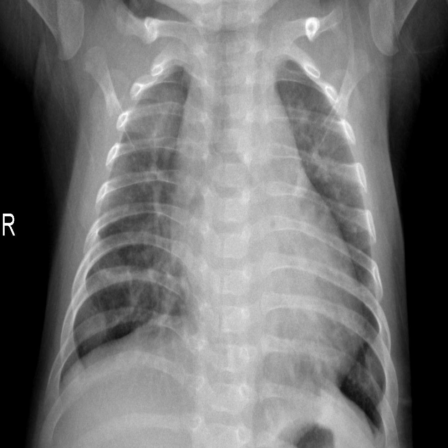

Raw Logits:                   tensor([[0.0672, 0.2653]], device='cuda:0')
Prediction Probabilities:     tensor([[0.4506, 0.5494]], device='cuda:0')
Prediction Labels:            1

Prediction: PNEUMONIA
Target: PNEUMONIA


In [26]:
random_pred(train_dataset, model, classes=train_dataset.classes)

In [27]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
confmat_metric = ConfusionMatrix(task='multiclass', num_classes=2).to(device)
auroc_metric = AUROC(task='multiclass', num_classes=2).to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)

In [28]:
train_losses = []
val_losses = []
accs = []
precs = []
recs = []
f1s = []
aurocs = []

In [29]:
train_losses, val_losses, accs, precs, recs, f1s, aurocs

([], [], [], [], [], [], [])

  0%|          | 0/39 [00:00<?, ?it/s]

Cross Entropy Loss: 0.6934
Accuracy: 37.98% | Precision: 50.76% | Recall: 25.64% | F1 Score: 34.07%
AUROC: 0.3695


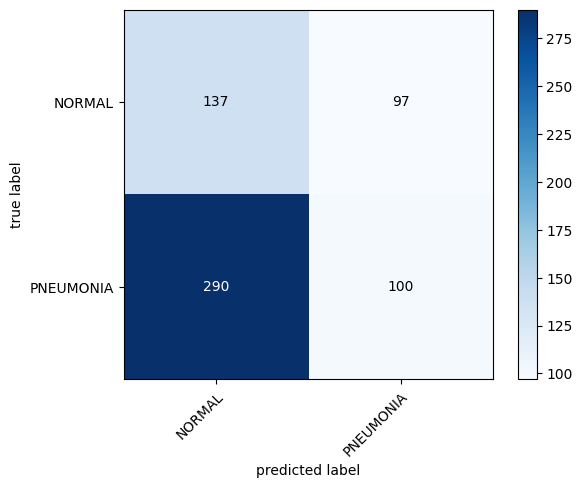

In [30]:
loss = 0
auroc = 0
master_confmat = torch.zeros(2, 2).to(device)

model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        probs = logits.softmax(1)
        labels = probs.argmax(1)

        loss += criterion(logits, y).item()
        auroc += auroc_metric(probs, y).item()
        master_confmat += confmat_metric(labels, y)

loss /= len(test_dataloader)
auroc /= len(test_dataloader)
acc = confmat_to_accuracy(master_confmat)
prec = confmat_to_precision(master_confmat)
rec = confmat_to_recall(master_confmat)
f1 = confmat_to_f1score(master_confmat)

train_losses.append(loss)
val_losses.append(loss)
accs.append(acc)
precs.append(prec)
recs.append(rec)
f1s.append(f1)
aurocs.append(auroc)

print(f'Cross Entropy Loss: {loss:.4f}')
print(f'Accuracy: {acc * 100:.2f}% | Precision: {prec * 100:.2f}% | Recall: {rec * 100:.2f}% | F1 Score: {f1 * 100:.2f}%')
print(f'AUROC: {auroc:.4f}')

fig, ax = plot_confusion_matrix(
    conf_mat=master_confmat.cpu().numpy(),
    class_names=train_dataset.classes,
    colorbar=True
)

In [31]:
best_acc = acc
best_acc_epoch = 0

In [32]:
prev_size = len(train_losses)

for epoch in tqdm(range(EPOCHS)):
    train_loss = 0
    val_loss = 0
    auroc = 0
    master_confmat = torch.zeros(2, 2).to(device)

    model.train()
    for X, y in tqdm(train_dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(test_dataloader):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            probs = logits.softmax(1)
            labels = probs.argmax(1)

            val_loss += criterion(logits, y).item()
            auroc += auroc_metric(probs, y).item()
            master_confmat += confmat_metric(labels, y)

    train_loss /= len(train_dataloader)
    val_loss /= len(test_dataloader)
    auroc /= len(test_dataloader)
    acc = confmat_to_accuracy(master_confmat)
    prec = confmat_to_precision(master_confmat)
    rec = confmat_to_recall(master_confmat)
    f1 = confmat_to_f1score(master_confmat)

    print(f'Epoch: {epoch + prev_size}/{EPOCHS + prev_size - 1}')
    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    print(f'Accuracy: {acc * 100:.2f}% | Precision: {prec * 100:.2f}% | Recall: {rec * 100:.2f}% | F1 Score: {f1 * 100:.2f}%')
    print(f'AUROC: {auroc:.4f}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)
    aurocs.append(auroc)

    if acc > best_acc:
        model_name = f'{unique_file_namer(model.__class__.__name__)}.pth'
        model_path = os.path.join(model_save_path, model_name)
        torch.save(model.state_dict(), model_path)
        print('>>> Model saved!')
        print(model_path)

        best_acc = acc
        best_acc_epoch = epoch + prev_size
    
    # reloading the best model yet every 5 epochs
    if epoch % 5 == 4:
        best_model_name = sorted(os.listdir(model_save_path))[-1]
        best_model_path = os.path.join(model_save_path, best_model_name)
        print('Reloaded:', best_model_path)

        model.load_state_dict(torch.load(best_model_path))

    print('\n' + '=' * 80 + '\n')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 1/100
Train Loss: 0.6947 | Val Loss: 0.6246
Accuracy: 46.79% | Precision: 68.12% | Recall: 27.95% | F1 Score: 39.64%
AUROC: 0.5602
>>> Model saved!
/kaggle/working/models/2024-05-24_07-55-29_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 2/100
Train Loss: 0.5978 | Val Loss: 0.5546
Accuracy: 60.26% | Precision: 86.22% | Recall: 43.33% | F1 Score: 57.68%
AUROC: 0.7800
>>> Model saved!
/kaggle/working/models/2024-05-24_07-58-06_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 3/100
Train Loss: 0.5274 | Val Loss: 0.5001
Accuracy: 69.07% | Precision: 91.91% | Recall: 55.38% | F1 Score: 69.12%
AUROC: 0.8736
>>> Model saved!
/kaggle/working/models/2024-05-24_08-00-43_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 4/100
Train Loss: 0.4662 | Val Loss: 0.4658
Accuracy: 77.24% | Precision: 93.36% | Recall: 68.46% | F1 Score: 78.99%
AUROC: 0.9085
>>> Model saved!
/kaggle/working/models/2024-05-24_08-03-19_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 5/100
Train Loss: 0.4176 | Val Loss: 0.4044
Accuracy: 74.84% | Precision: 95.33% | Recall: 62.82% | F1 Score: 75.73%
AUROC: 0.9352
Reloaded: /kaggle/working/models/2024-05-24_08-03-19_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 6/100
Train Loss: 0.4132 | Val Loss: 0.4081
Accuracy: 75.32% | Precision: 96.09% | Recall: 63.08% | F1 Score: 76.16%
AUROC: 0.9268




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 7/100
Train Loss: 0.3790 | Val Loss: 0.3826
Accuracy: 82.85% | Precision: 95.21% | Recall: 76.41% | F1 Score: 84.78%
AUROC: 0.9315
>>> Model saved!
/kaggle/working/models/2024-05-24_08-11-10_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 8/100
Train Loss: 0.3462 | Val Loss: 0.3477
Accuracy: 83.17% | Precision: 96.12% | Recall: 76.15% | F1 Score: 84.98%
AUROC: 0.9342
>>> Model saved!
/kaggle/working/models/2024-05-24_08-13-45_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 9/100
Train Loss: 0.3235 | Val Loss: 0.3162
Accuracy: 83.81% | Precision: 95.87% | Recall: 77.44% | F1 Score: 85.67%
AUROC: 0.9411
>>> Model saved!
/kaggle/working/models/2024-05-24_08-16-17_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 10/100
Train Loss: 0.3036 | Val Loss: 0.3121
Accuracy: 86.70% | Precision: 95.82% | Recall: 82.31% | F1 Score: 88.55%
AUROC: 0.9344
>>> Model saved!
/kaggle/working/models/2024-05-24_08-18-53_PneumoniaDetector_100_1.00e-07_16.pth
Reloaded: /kaggle/working/models/2024-05-24_08-18-53_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 11/100
Train Loss: 0.2887 | Val Loss: 0.3101
Accuracy: 87.50% | Precision: 94.83% | Recall: 84.62% | F1 Score: 89.43%
AUROC: 0.9483
>>> Model saved!
/kaggle/working/models/2024-05-24_08-21-30_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 12/100
Train Loss: 0.2657 | Val Loss: 0.2943
Accuracy: 88.14% | Precision: 94.89% | Recall: 85.64% | F1 Score: 90.03%
AUROC: 0.9493
>>> Model saved!
/kaggle/working/models/2024-05-24_08-24-07_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 13/100
Train Loss: 0.2534 | Val Loss: 0.2810
Accuracy: 88.14% | Precision: 94.89% | Recall: 85.64% | F1 Score: 90.03%
AUROC: 0.9462




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 14/100
Train Loss: 0.2483 | Val Loss: 0.2839
Accuracy: 87.82% | Precision: 93.85% | Recall: 86.15% | F1 Score: 89.84%
AUROC: 0.9542




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 15/100
Train Loss: 0.2400 | Val Loss: 0.2829
Accuracy: 87.98% | Precision: 93.39% | Recall: 86.92% | F1 Score: 90.04%
AUROC: 0.9442
Reloaded: /kaggle/working/models/2024-05-24_08-24-07_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 16/100
Train Loss: 0.2586 | Val Loss: 0.2906
Accuracy: 88.14% | Precision: 93.89% | Recall: 86.67% | F1 Score: 90.13%
AUROC: 0.9465




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 17/100
Train Loss: 0.2402 | Val Loss: 0.2815
Accuracy: 88.30% | Precision: 94.90% | Recall: 85.90% | F1 Score: 90.17%
AUROC: 0.9448
>>> Model saved!
/kaggle/working/models/2024-05-24_08-36-54_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 18/100
Train Loss: 0.2340 | Val Loss: 0.2812
Accuracy: 88.30% | Precision: 93.91% | Recall: 86.92% | F1 Score: 90.28%
AUROC: 0.9448




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 19/100
Train Loss: 0.2271 | Val Loss: 0.2509
Accuracy: 88.30% | Precision: 95.16% | Recall: 85.64% | F1 Score: 90.15%
AUROC: 0.9419




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 20/100
Train Loss: 0.2301 | Val Loss: 0.2665
Accuracy: 87.98% | Precision: 93.39% | Recall: 86.92% | F1 Score: 90.04%
AUROC: 0.9505
Reloaded: /kaggle/working/models/2024-05-24_08-36-54_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 21/100
Train Loss: 0.2353 | Val Loss: 0.2750
Accuracy: 88.46% | Precision: 94.92% | Recall: 86.15% | F1 Score: 90.32%
AUROC: 0.9424
>>> Model saved!
/kaggle/working/models/2024-05-24_08-47-20_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 22/100
Train Loss: 0.2265 | Val Loss: 0.2679
Accuracy: 88.30% | Precision: 93.91% | Recall: 86.92% | F1 Score: 90.28%
AUROC: 0.9519




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 23/100
Train Loss: 0.2293 | Val Loss: 0.2548
Accuracy: 88.62% | Precision: 94.93% | Recall: 86.41% | F1 Score: 90.47%
AUROC: 0.9500
>>> Model saved!
/kaggle/working/models/2024-05-24_08-52-27_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 24/100
Train Loss: 0.2158 | Val Loss: 0.2592
Accuracy: 88.78% | Precision: 94.69% | Recall: 86.92% | F1 Score: 90.64%
AUROC: 0.9502
>>> Model saved!
/kaggle/working/models/2024-05-24_08-54-59_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 25/100
Train Loss: 0.2180 | Val Loss: 0.2448
Accuracy: 88.78% | Precision: 94.94% | Recall: 86.67% | F1 Score: 90.62%
AUROC: 0.9568
Reloaded: /kaggle/working/models/2024-05-24_08-54-59_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 26/100
Train Loss: 0.2083 | Val Loss: 0.2665
Accuracy: 88.14% | Precision: 93.41% | Recall: 87.18% | F1 Score: 90.19%
AUROC: 0.9486




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 27/100
Train Loss: 0.2169 | Val Loss: 0.2335
Accuracy: 88.62% | Precision: 95.18% | Recall: 86.15% | F1 Score: 90.44%
AUROC: 0.9491




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 28/100
Train Loss: 0.1971 | Val Loss: 0.2597
Accuracy: 88.94% | Precision: 94.46% | Recall: 87.44% | F1 Score: 90.81%
AUROC: 0.9553
>>> Model saved!
/kaggle/working/models/2024-05-24_09-05-20_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 29/100
Train Loss: 0.1957 | Val Loss: 0.2700
Accuracy: 88.94% | Precision: 94.46% | Recall: 87.44% | F1 Score: 90.81%
AUROC: 0.9544




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 30/100
Train Loss: 0.1917 | Val Loss: 0.2568
Accuracy: 88.94% | Precision: 94.46% | Recall: 87.44% | F1 Score: 90.81%
AUROC: 0.9482
Reloaded: /kaggle/working/models/2024-05-24_09-05-20_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 31/100
Train Loss: 0.2082 | Val Loss: 0.2380
Accuracy: 88.78% | Precision: 94.94% | Recall: 86.67% | F1 Score: 90.62%
AUROC: 0.9502




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 32/100
Train Loss: 0.2015 | Val Loss: 0.2615
Accuracy: 89.26% | Precision: 94.49% | Recall: 87.95% | F1 Score: 91.10%
AUROC: 0.9520
>>> Model saved!
/kaggle/working/models/2024-05-24_09-15-34_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 33/100
Train Loss: 0.1816 | Val Loss: 0.2669
Accuracy: 89.74% | Precision: 94.54% | Recall: 88.72% | F1 Score: 91.53%
AUROC: 0.9650
>>> Model saved!
/kaggle/working/models/2024-05-24_09-18-04_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 34/100
Train Loss: 0.1880 | Val Loss: 0.2741
Accuracy: 89.58% | Precision: 94.52% | Recall: 88.46% | F1 Score: 91.39%
AUROC: 0.9611




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 35/100
Train Loss: 0.1762 | Val Loss: 0.2601
Accuracy: 89.74% | Precision: 94.54% | Recall: 88.72% | F1 Score: 91.53%
AUROC: 0.9591
Reloaded: /kaggle/working/models/2024-05-24_09-18-04_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 36/100
Train Loss: 0.1847 | Val Loss: 0.2706
Accuracy: 89.74% | Precision: 94.54% | Recall: 88.72% | F1 Score: 91.53%
AUROC: 0.9566




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 37/100
Train Loss: 0.1838 | Val Loss: 0.2655
Accuracy: 89.42% | Precision: 94.26% | Recall: 88.46% | F1 Score: 91.27%
AUROC: 0.9467




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 38/100
Train Loss: 0.1842 | Val Loss: 0.2722
Accuracy: 89.74% | Precision: 94.29% | Recall: 88.97% | F1 Score: 91.56%
AUROC: 0.9589




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 39/100
Train Loss: 0.1662 | Val Loss: 0.2442
Accuracy: 89.74% | Precision: 94.29% | Recall: 88.97% | F1 Score: 91.56%
AUROC: 0.9613




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 40/100
Train Loss: 0.1705 | Val Loss: 0.2589
Accuracy: 89.90% | Precision: 94.07% | Recall: 89.49% | F1 Score: 91.72%
AUROC: 0.9526
>>> Model saved!
/kaggle/working/models/2024-05-24_09-35-36_PneumoniaDetector_100_1.00e-07_16.pth
Reloaded: /kaggle/working/models/2024-05-24_09-35-36_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 41/100
Train Loss: 0.1734 | Val Loss: 0.2545
Accuracy: 90.06% | Precision: 94.32% | Recall: 89.49% | F1 Score: 91.84%
AUROC: 0.9588
>>> Model saved!
/kaggle/working/models/2024-05-24_09-38-09_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 42/100
Train Loss: 0.1677 | Val Loss: 0.2357
Accuracy: 90.22% | Precision: 95.57% | Recall: 88.46% | F1 Score: 91.88%
AUROC: 0.9484
>>> Model saved!
/kaggle/working/models/2024-05-24_09-40-45_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 43/100
Train Loss: 0.1556 | Val Loss: 0.2664
Accuracy: 90.22% | Precision: 93.87% | Recall: 90.26% | F1 Score: 92.03%
AUROC: 0.9576




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 44/100
Train Loss: 0.1593 | Val Loss: 0.2685
Accuracy: 90.22% | Precision: 93.40% | Recall: 90.77% | F1 Score: 92.07%
AUROC: 0.9599




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 45/100
Train Loss: 0.1610 | Val Loss: 0.2917
Accuracy: 90.54% | Precision: 92.99% | Recall: 91.79% | F1 Score: 92.39%
AUROC: 0.9626
>>> Model saved!
/kaggle/working/models/2024-05-24_09-48-26_PneumoniaDetector_100_1.00e-07_16.pth
Reloaded: /kaggle/working/models/2024-05-24_09-48-26_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 46/100
Train Loss: 0.1551 | Val Loss: 0.2863
Accuracy: 90.54% | Precision: 92.99% | Recall: 91.79% | F1 Score: 92.39%
AUROC: 0.9595




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 47/100
Train Loss: 0.1518 | Val Loss: 0.2688
Accuracy: 90.06% | Precision: 92.93% | Recall: 91.03% | F1 Score: 91.97%
AUROC: 0.9606




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 48/100
Train Loss: 0.1514 | Val Loss: 0.2790
Accuracy: 90.87% | Precision: 93.02% | Recall: 92.31% | F1 Score: 92.66%
AUROC: 0.9635
>>> Model saved!
/kaggle/working/models/2024-05-24_09-56-07_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 49/100
Train Loss: 0.1473 | Val Loss: 0.2806
Accuracy: 91.03% | Precision: 93.04% | Recall: 92.56% | F1 Score: 92.80%
AUROC: 0.9651
>>> Model saved!
/kaggle/working/models/2024-05-24_09-58-43_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 50/100
Train Loss: 0.1427 | Val Loss: 0.2755
Accuracy: 90.87% | Precision: 93.02% | Recall: 92.31% | F1 Score: 92.66%
AUROC: 0.9637
Reloaded: /kaggle/working/models/2024-05-24_09-58-43_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 51/100
Train Loss: 0.1477 | Val Loss: 0.2852
Accuracy: 91.19% | Precision: 93.06% | Recall: 92.82% | F1 Score: 92.94%
AUROC: 0.9568
>>> Model saved!
/kaggle/working/models/2024-05-24_10-04-00_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 52/100
Train Loss: 0.1449 | Val Loss: 0.2520
Accuracy: 90.54% | Precision: 94.13% | Recall: 90.51% | F1 Score: 92.29%
AUROC: 0.9583




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 53/100
Train Loss: 0.1409 | Val Loss: 0.2696
Accuracy: 91.03% | Precision: 93.26% | Recall: 92.31% | F1 Score: 92.78%
AUROC: 0.9586




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 54/100
Train Loss: 0.1391 | Val Loss: 0.2635
Accuracy: 90.87% | Precision: 93.25% | Recall: 92.05% | F1 Score: 92.65%
AUROC: 0.9597




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 55/100
Train Loss: 0.1403 | Val Loss: 0.2704
Accuracy: 91.19% | Precision: 93.06% | Recall: 92.82% | F1 Score: 92.94%
AUROC: 0.9629
Reloaded: /kaggle/working/models/2024-05-24_10-04-00_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 56/100
Train Loss: 0.1443 | Val Loss: 0.2621
Accuracy: 90.87% | Precision: 93.02% | Recall: 92.31% | F1 Score: 92.66%
AUROC: 0.9608




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 57/100
Train Loss: 0.1358 | Val Loss: 0.2524
Accuracy: 90.22% | Precision: 92.95% | Recall: 91.28% | F1 Score: 92.11%
AUROC: 0.9643




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 58/100
Train Loss: 0.1300 | Val Loss: 0.2870
Accuracy: 91.99% | Precision: 92.93% | Recall: 94.36% | F1 Score: 93.64%
AUROC: 0.9646
>>> Model saved!
/kaggle/working/models/2024-05-24_10-22-39_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 59/100
Train Loss: 0.1398 | Val Loss: 0.2808
Accuracy: 91.83% | Precision: 93.13% | Recall: 93.85% | F1 Score: 93.49%
AUROC: 0.9602




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 60/100
Train Loss: 0.1386 | Val Loss: 0.3243
Accuracy: 92.31% | Precision: 92.75% | Recall: 95.13% | F1 Score: 93.92%
AUROC: 0.9575
>>> Model saved!
/kaggle/working/models/2024-05-24_10-27-56_PneumoniaDetector_100_1.00e-07_16.pth
Reloaded: /kaggle/working/models/2024-05-24_10-27-56_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 61/100
Train Loss: 0.1394 | Val Loss: 0.2998
Accuracy: 92.31% | Precision: 92.75% | Recall: 95.13% | F1 Score: 93.92%
AUROC: 0.9659




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 62/100
Train Loss: 0.1287 | Val Loss: 0.2534
Accuracy: 91.51% | Precision: 93.09% | Recall: 93.33% | F1 Score: 93.21%
AUROC: 0.9659




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 63/100
Train Loss: 0.1290 | Val Loss: 0.3383
Accuracy: 92.15% | Precision: 92.52% | Recall: 95.13% | F1 Score: 93.81%
AUROC: 0.9567




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 64/100
Train Loss: 0.1289 | Val Loss: 0.2581
Accuracy: 91.67% | Precision: 93.56% | Recall: 93.08% | F1 Score: 93.32%
AUROC: 0.9622




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 65/100
Train Loss: 0.1271 | Val Loss: 0.3063
Accuracy: 92.15% | Precision: 92.52% | Recall: 95.13% | F1 Score: 93.81%
AUROC: 0.9598
Reloaded: /kaggle/working/models/2024-05-24_10-27-56_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 66/100
Train Loss: 0.1376 | Val Loss: 0.3392
Accuracy: 92.79% | Precision: 92.18% | Recall: 96.67% | F1 Score: 94.37%
AUROC: 0.9700
>>> Model saved!
/kaggle/working/models/2024-05-24_10-43-59_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 67/100
Train Loss: 0.1288 | Val Loss: 0.3139
Accuracy: 92.31% | Precision: 92.75% | Recall: 95.13% | F1 Score: 93.92%
AUROC: 0.9612




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 68/100
Train Loss: 0.1325 | Val Loss: 0.2831
Accuracy: 91.83% | Precision: 92.91% | Recall: 94.10% | F1 Score: 93.50%
AUROC: 0.9616




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 69/100
Train Loss: 0.1398 | Val Loss: 0.3098
Accuracy: 92.63% | Precision: 92.57% | Recall: 95.90% | F1 Score: 94.21%
AUROC: 0.9674




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 70/100
Train Loss: 0.1289 | Val Loss: 0.3836
Accuracy: 92.47% | Precision: 91.33% | Recall: 97.18% | F1 Score: 94.16%
AUROC: 0.9491
Reloaded: /kaggle/working/models/2024-05-24_10-43-59_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 71/100
Train Loss: 0.1305 | Val Loss: 0.2835
Accuracy: 92.15% | Precision: 92.73% | Recall: 94.87% | F1 Score: 93.79%
AUROC: 0.9645




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 72/100
Train Loss: 0.1216 | Val Loss: 0.3254
Accuracy: 92.47% | Precision: 92.56% | Recall: 95.64% | F1 Score: 94.07%
AUROC: 0.9578




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 73/100
Train Loss: 0.1327 | Val Loss: 0.2772
Accuracy: 91.83% | Precision: 92.91% | Recall: 94.10% | F1 Score: 93.50%
AUROC: 0.9625




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 74/100
Train Loss: 0.1247 | Val Loss: 0.3347
Accuracy: 92.63% | Precision: 92.36% | Recall: 96.15% | F1 Score: 94.22%
AUROC: 0.9595




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 75/100
Train Loss: 0.1216 | Val Loss: 0.2987
Accuracy: 92.31% | Precision: 92.75% | Recall: 95.13% | F1 Score: 93.92%
AUROC: 0.9614
Reloaded: /kaggle/working/models/2024-05-24_10-43-59_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 76/100
Train Loss: 0.1233 | Val Loss: 0.2580
Accuracy: 91.83% | Precision: 92.91% | Recall: 94.10% | F1 Score: 93.50%
AUROC: 0.9714




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 77/100
Train Loss: 0.1201 | Val Loss: 0.3018
Accuracy: 92.15% | Precision: 92.52% | Recall: 95.13% | F1 Score: 93.81%
AUROC: 0.9632




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 78/100
Train Loss: 0.1194 | Val Loss: 0.2789
Accuracy: 91.83% | Precision: 93.13% | Recall: 93.85% | F1 Score: 93.49%
AUROC: 0.9610




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 79/100
Train Loss: 0.1250 | Val Loss: 0.2882
Accuracy: 92.31% | Precision: 93.18% | Recall: 94.62% | F1 Score: 93.89%
AUROC: 0.9537




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 80/100
Train Loss: 0.1211 | Val Loss: 0.3663
Accuracy: 92.79% | Precision: 91.77% | Recall: 97.18% | F1 Score: 94.40%
AUROC: 0.9626
Reloaded: /kaggle/working/models/2024-05-24_10-43-59_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 81/100
Train Loss: 0.1378 | Val Loss: 0.2986
Accuracy: 92.31% | Precision: 92.75% | Recall: 95.13% | F1 Score: 93.92%
AUROC: 0.9641




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 82/100
Train Loss: 0.1345 | Val Loss: 0.2865
Accuracy: 91.99% | Precision: 92.93% | Recall: 94.36% | F1 Score: 93.64%
AUROC: 0.9526




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 83/100
Train Loss: 0.1265 | Val Loss: 0.2858
Accuracy: 92.15% | Precision: 92.52% | Recall: 95.13% | F1 Score: 93.81%
AUROC: 0.9717




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 84/100
Train Loss: 0.1139 | Val Loss: 0.3071
Accuracy: 92.15% | Precision: 92.52% | Recall: 95.13% | F1 Score: 93.81%
AUROC: 0.9688




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch: 85/100
Train Loss: 0.1220 | Val Loss: 0.3174
Accuracy: 92.31% | Precision: 92.33% | Recall: 95.64% | F1 Score: 93.95%
AUROC: 0.9422
Reloaded: /kaggle/working/models/2024-05-24_10-43-59_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 86/100
Train Loss: 0.1354 | Val Loss: 0.3095
Accuracy: 92.31% | Precision: 92.75% | Recall: 95.13% | F1 Score: 93.92%
AUROC: 0.9632




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 87/100
Train Loss: 0.1404 | Val Loss: 0.3481
Accuracy: 92.63% | Precision: 91.95% | Recall: 96.67% | F1 Score: 94.25%
AUROC: 0.9630




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 88/100
Train Loss: 0.1287 | Val Loss: 0.3019
Accuracy: 92.15% | Precision: 92.52% | Recall: 95.13% | F1 Score: 93.81%
AUROC: 0.9642




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 89/100
Train Loss: 0.1295 | Val Loss: 0.3288
Accuracy: 92.79% | Precision: 92.59% | Recall: 96.15% | F1 Score: 94.34%
AUROC: 0.9622




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 90/100
Train Loss: 0.1298 | Val Loss: 0.3249
Accuracy: 92.47% | Precision: 92.56% | Recall: 95.64% | F1 Score: 94.07%
AUROC: 0.9524
Reloaded: /kaggle/working/models/2024-05-24_10-43-59_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 91/100
Train Loss: 0.1277 | Val Loss: 0.2731
Accuracy: 91.99% | Precision: 92.93% | Recall: 94.36% | F1 Score: 93.64%
AUROC: 0.9674




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 92/100
Train Loss: 0.1306 | Val Loss: 0.2850
Accuracy: 92.31% | Precision: 92.96% | Recall: 94.87% | F1 Score: 93.91%
AUROC: 0.9615




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 93/100
Train Loss: 0.1251 | Val Loss: 0.3478
Accuracy: 92.63% | Precision: 92.36% | Recall: 96.15% | F1 Score: 94.22%
AUROC: 0.9641




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 94/100
Train Loss: 0.1231 | Val Loss: 0.3021
Accuracy: 92.15% | Precision: 92.52% | Recall: 95.13% | F1 Score: 93.81%
AUROC: 0.9624




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 95/100
Train Loss: 0.1248 | Val Loss: 0.3624
Accuracy: 91.99% | Precision: 90.67% | Recall: 97.18% | F1 Score: 93.81%
AUROC: 0.9612
Reloaded: /kaggle/working/models/2024-05-24_10-43-59_PneumoniaDetector_100_1.00e-07_16.pth




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 96/100
Train Loss: 0.1287 | Val Loss: 0.3053
Accuracy: 92.31% | Precision: 92.75% | Recall: 95.13% | F1 Score: 93.92%
AUROC: 0.9631




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 97/100
Train Loss: 0.1304 | Val Loss: 0.3185
Accuracy: 92.15% | Precision: 92.52% | Recall: 95.13% | F1 Score: 93.81%
AUROC: 0.9615




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 98/100
Train Loss: 0.1270 | Val Loss: 0.3471
Accuracy: 92.63% | Precision: 92.36% | Recall: 96.15% | F1 Score: 94.22%
AUROC: 0.9619




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 99/100
Train Loss: 0.1277 | Val Loss: 0.3193
Accuracy: 92.47% | Precision: 92.56% | Recall: 95.64% | F1 Score: 94.07%
AUROC: 0.9644




  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 100/100
Train Loss: 0.1208 | Val Loss: 0.2999
Accuracy: 92.15% | Precision: 92.52% | Recall: 95.13% | F1 Score: 93.81%
AUROC: 0.9644
Reloaded: /kaggle/working/models/2024-05-24_10-43-59_PneumoniaDetector_100_1.00e-07_16.pth




/tmp/ipykernel_25/1575607373.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


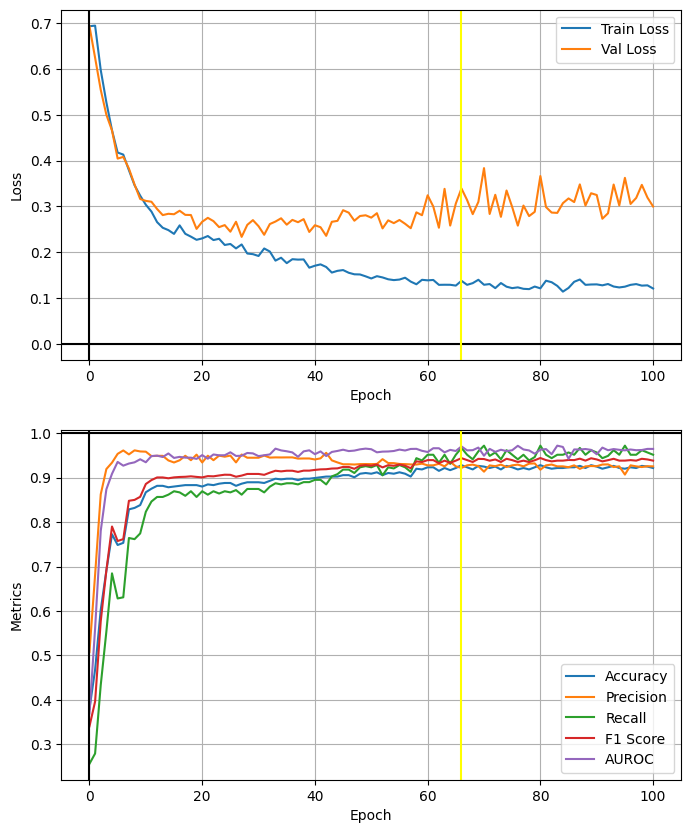

In [33]:
plt.figure(figsize=(8, 10))
plt.title(f'{model.__class__.__name__} Training/Validation Plot')
plt.axis('off')

# ========== (1) ==========

plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
if len(train_losses) <= 20:
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.axvline(best_acc_epoch, color='yellow')
plt.legend(loc='best')
# plt.ylim(-0.05, 1)

# ========== (2) ==========

plt.subplot(2, 1, 2)
plt.plot(accs, label='Accuracy')
plt.plot(precs, label='Precision')
plt.plot(recs, label='Recall')
plt.plot(f1s, label='F1 Score')
plt.plot(aurocs, label='AUROC')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
if len(train_losses) <= 20:
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.axhline(1, color='black')
plt.axvline(0, color='black')
plt.axvline(best_acc_epoch, color='yellow')
plt.legend(loc='best')

plot_file_name = f'{unique_file_namer(model.__class__.__name__)}.png'
plt.savefig(os.path.join(plot_save_path, plot_file_name), bbox_inches='tight')

plt.show()

In [34]:
best_model_name = sorted(os.listdir(model_save_path))[-1]
best_model_path = os.path.join(model_save_path, best_model_name)
print(best_model_path)

model.load_state_dict(torch.load(best_model_path))

/kaggle/working/models/2024-05-24_10-43-59_PneumoniaDetector_100_1.00e-07_16.pth


<All keys matched successfully>

  0%|          | 0/39 [00:00<?, ?it/s]

Cross Entropy Loss: 0.3410 
Accuracy: 92.79% | Precision: 92.18% | Recall: 96.67% | F1 Score: 94.37% 
AUROC: 0.9634


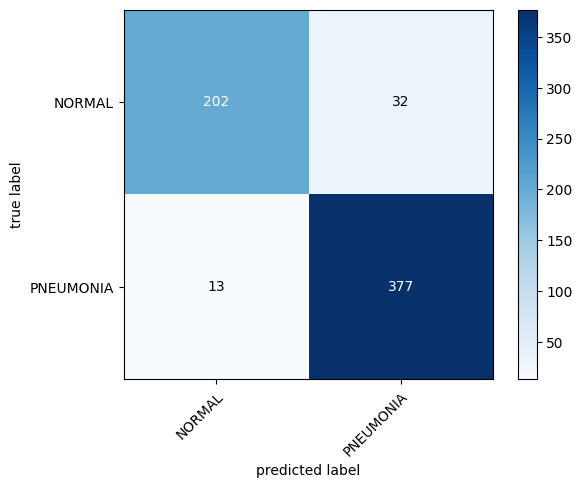

In [35]:
loss = 0
auroc = 0
master_confmat = torch.zeros(2, 2).to(device)

model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        probs = logits.softmax(1)
        labels = probs.argmax(1)

        loss += criterion(logits, y).item()
        auroc += auroc_metric(probs, y).item()
        master_confmat += confmat_metric(labels, y)

loss /= len(test_dataloader)
auroc /= len(test_dataloader)
acc = confmat_to_accuracy(master_confmat)
prec = confmat_to_precision(master_confmat)
rec = confmat_to_recall(master_confmat)
f1 = confmat_to_f1score(master_confmat)

result = f'Cross Entropy Loss: {loss:.4f} \nAccuracy: {acc * 100:.2f}% | Precision: {prec * 100:.2f}% | Recall: {rec * 100:.2f}% | F1 Score: {f1 * 100:.2f}% \nAUROC: {auroc:.4f}'
print(result)

result_file_name = f'{unique_file_namer(model.__class__.__name__)}.txt'
with open(os.path.join(result_save_path, result_file_name), 'w') as f:
    f.write(result)

fig, ax = plot_confusion_matrix(
    conf_mat=master_confmat.cpu().numpy(),
    class_names=test_dataset.classes,
    colorbar=True
)

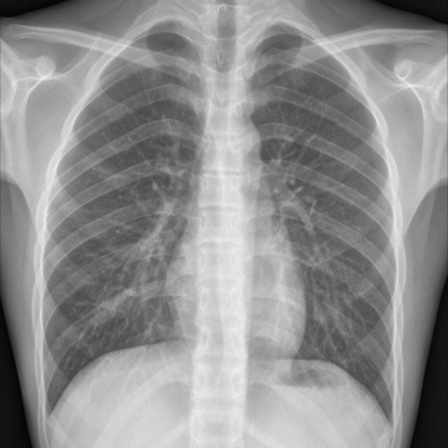

Raw Logits:                   tensor([[ 1.5248, -1.7471]], device='cuda:0')
Prediction Probabilities:     tensor([[0.9635, 0.0365]], device='cuda:0')
Prediction Labels:            0

Prediction: NORMAL
Target: NORMAL


In [36]:
random_pred(test_dataset, model, classes=test_dataset.classes)